In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Load data

In [2]:
# # description file -- not pandas-friendly
# df_dict = pd.read_excel('../data/pulse2020_data.dictionary_CSV_01.xlsx')
WEEK_IDX_RANGE = range(1, 14)

data = {
    n: pd.read_csv(f'../data/pulse2020_puf_{n:02d}.csv')
    for n in WEEK_IDX_RANGE
}
df = pd.read_csv('../data/pulse2020_puf_01.csv')

In [3]:
# check each participant has one entry in a given survey
for n in WEEK_IDX_RANGE:
    assert len(data[n]['SCRAM'].unique()) == len(data[n])

In [8]:
# base_week_idx = 6

# init_scram_set = set(data[base_week_idx]['SCRAM'])
# people_funnel = [len(init_scram_set)]

# for n in WEEK_IDX_RANGE[base_week_idx:]:
#     intersect_scram_set = init_scram_set.intersection(set(data[n]['SCRAM']))
#     people_funnel.append(len(intersect_scram_set))

# people_funnel

In [25]:
from functools import reduce

def get_participants_counts_matrix(data):
    df_list = []
    for week_idx, tmp_df in data.items():
        # make a df with column WEEK IDX 
        # which is has value WEEK IDX for participants of that week's survey
        tmp_df = tmp_df[['SCRAM']].copy()
        tmp_df.index = tmp_df.SCRAM
        tmp_df[str(week_idx)] = week_idx
        del tmp_df['SCRAM']
        df_list.append(tmp_df)

    # merge all dfs on SCRAM
    kwargs = dict(how='outer', left_index=True, right_index=True, )
    out = reduce(lambda x, y: pd.merge(x, y, **kwargs), df_list)

    # create matrix of size (n, k) = (num of all unique participants, number of weeks)
    # that propagates the idx of week when a person first joined 
    # to all following weeks IN WHICH this person participated
    out_nk = out.values
    is_valid_nk = np.isfinite(out_nk)
    out_nk[~is_valid_nk] = 100000
    out_nk = np.minimum.accumulate(out_nk, axis=1)
    out_nk[~is_valid_nk] = -1

    dim_k = out_nk.shape[1]
    # where k means from which week a person started to participate
    # and w is the week we are looking at to
    counts_kw = np.zeros((dim_k, dim_k))
    for k_idx in range(dim_k):
        counts_kw[k_idx] = (out_nk == k_idx + 1).sum(axis=0)

    df = pd.DataFrame(data=counts_kw, 
                      index=np.arange(1, dim_k + 1), 
                      columns=np.arange(1, dim_k + 1))
    df.index.name = 'start week idx'
    return df

In [54]:
df_kw = get_participants_counts_matrix(data)
# df_kw.to_csv('../data/participants_counts.csv')
counts_kw = df_kw.values

In [48]:
# check sum of paricipants for each week is same
weekly_num_people = np.array([len(data[i])for i in WEEK_IDX_RANGE])
assert ((df_kw.values.sum(axis=0) - weekly_num_people) == 0).all()

unique_person_ids = set()
for i in WEEK_IDX_RANGE:
    unique_person_ids.update(data[i]['SCRAM'].values)
assert np.diag(df_kw.values).sum() == len(unique_person_ids)

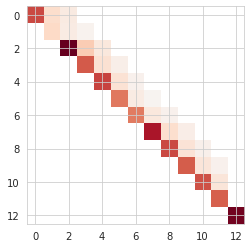

In [53]:
from matplotlib import cm

counts_kw_copy = counts_kw.copy()
counts_kw_copy[counts_kw_copy == 0] = np.nan
plt.imshow(counts_kw_copy, vmin=-counts_kw.max(), vmax=counts_kw.max(), cmap=cm.RdBu_r)

In [50]:
import seaborn as sns
sns.set_style("whitegrid")

import matplotlib as mpl
import numpy as np

# Set the default color cycle

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["r", "k", "c"]) 

In [51]:
clrs = sns.color_palette('gist_ncar', n_colors=13)

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=clrs) 

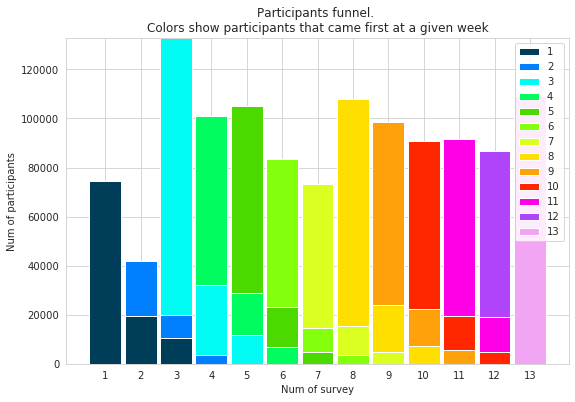

In [52]:
fig, axis = plt.subplots(1, 1, figsize=(9,6))

shifted_cum_counts_kw = np.concatenate((np.zeros(n_k)[None, :], counts_kw.cumsum(axis=0)), axis=0)
x_k = np.arange(1, n_k + 1)

for k_idx in range(n_k):
    p1 = axis.bar(x_k, counts_kw[k_idx], 0.9, 
                 bottom=shifted_cum_counts_kw[k_idx], label=k_idx + 1)
axis.xaxis.set_ticks(np.arange(1, 14, 1))
axis.set_title('Participants funnel. \nColors show participants that came first at a given week')
axis.set_xlabel('Num of survey')
axis.set_ylabel('Num of participants')
axis.legend()
fig.savefig('../figures/participants_funnel.png')

# EDA

In [17]:
race_from_num = {
    1: 'white',
    2: 'black',
    3: 'asian',
    4: 'other',
}

df['RRACE'].apply(lambda x: race_from_num[x]).value_counts()

white    61376
black     6258
other     3472
asian     3307
Name: RRACE, dtype: int64

In [ ]:
var = 'WRKLOSS'
